In [1]:
cd ..

d:\online class\DeepLearning\Object Detection


d:\online class\DeepLearning\Object Detection\venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
pwd

'd:\\online class\\DeepLearning\\Object Detection'

In [3]:
## Python in-built tools 
import os
import pickle
from tqdm import tqdm

## Data Science Tools 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
%matplotlib inline
import torch
import torch.nn as nn

## Image Processing Tools 
import cv2
import selectivesearch
from torch.utils.data import Dataset, DataLoader 


## Frameworks
from torchvision import transforms
from torchvision import models
from torchsummary import summary


Hyper Parameters

In [4]:
image_paths = "data/images/images"
csv_path = "data/df.csv"
batch_size = 2
n_epochs = 10
learning_rate = 1e-4
threshold_iou = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# open image datasets loading

In [5]:
class OpenImageDataset(Dataset):

    def __init__(self, image_paths, csv_path):
        super().__init__()
        self.image_paths = image_paths
        self.csv_path = csv_path
        self.df = pd.read_csv(csv_path)
        self.unique_images = self.df['ImageID'].unique()

    def __len__(self):
        return len(self.unique_images)
    
    def __getitem__(self, index):
        image_id = self.unique_images[index]
        image_full_path = os.path.join(os.getcwd(), self.image_paths, image_id + ".jpg")
        image = cv2.imread(image_full_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        h, w, _ = image.shape
        df = self.df.loc[self.df['ImageID'] == image_id]

        bboxes = df[['XMin', 'YMin', 'XMax', 'YMax']].values
        bboxes = (bboxes * np.array([w, h, w, h])).astype(np.uint16)

        classes = df['LabelName'].values
        return image, bboxes, classes, image_full_path

datasets = OpenImageDataset(image_paths, csv_path)
#datasets[]

In [6]:
len(datasets)

15225

<function matplotlib.pyplot.show(close=None, block=None)>

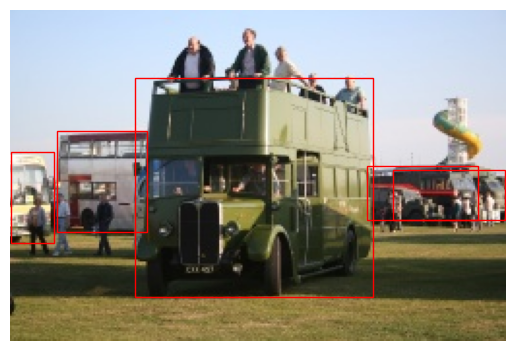

In [7]:
img, bbx, _, _ = datasets[14]
plt.imshow(img)
plt.axis('off')

for bb in bbx:
    rect = patches.Rectangle(bb[:2], bb[2]-bb[0], bb[3]-bb[1], edgecolor = 'r', facecolor = 'none', linewidth = 1)
    plt.gca().add_patch(rect)
plt.show


### Utils Function

In [8]:
def extract_candidates(img):
    _, regions = selectivesearch.selective_search(img, scale=4, min_size=20)
    candidates = []
    img_area = np.prod(img.shape[:2])
    for region in regions:
        if region['rect'] in candidates:
            continue
        if region['size'] < 0.05*img_area:
            continue
        if region['size'] > img_area:
            continue 
        candidates.append(region['rect'])
    return candidates

def extract_iou(bbox1, bbox2, epsilon=1e-5):
    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    
    x2 = min(bbox1[2], bbox2[2])
    y2 = min(bbox1[3], bbox2[3])

    width = x2 - x1
    height = y2 - y1

    if width < 0 or height < 0:
        return 0
    
    intersection_area = width * height 
    area_1 = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    area_2 = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])
    union_area = area_1 + area_2 - intersection_area
    return intersection_area / (union_area + epsilon)


In [9]:
# FULL_PATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
# # N = 100
# for i, (image, bboxes, classes, image_full_path) in enumerate(datasets):
#     # if i == N:
#     #     break

#     H, W, _ = image.shape
#     candidates = extract_candidates(image)
#     candidates = np.array([(x, y, x+w, y+h) for x, y, w, h in candidates])

#     clss, deltas, rois = [], [], []
#     ious = np.array([[extract_iou(candidate, bbox) for bbox in bboxes] for candidate in candidates])
    
#     for j, candidate in enumerate (candidates):
#         cx, cy, cX, cY = candidate
#         candidate_ious = ious[j]
#         best_iou_at = np.argmax(candidate_ious)
#         best_iou = candidate_ious[best_iou_at]
#         best_bb = _x, _y, _X, _Y = bboxes[best_iou_at]

#         if best_iou > threshold_iou:
#             clss.append(classes[best_iou_at])
#         else:
#             clss.append('background')

#         delta = np.array([_x - cx, _y - cy, _X - cX, _Y - cY]) / np.array([W, H, W, H])
#         deltas.append(delta)

#         rois.append(candidate / np.array([W, H, W, H]))

#     FULL_PATHS.append(image_full_path)
#     GTBBS.append(bboxes)
#     CLSS.append(clss)
#     DELTAS.append(deltas)
#     ROIS.append(rois)
#     IOUS.append(ious)


### Pickle Utils Function

In [10]:

def save_pickle(var, path):
    with open(path, 'wb') as file:
        pickle.dump(var, file)
        
def load_pickle(path):
    with open(path, 'rb') as file:
        return pickle.load(file)
        
# save_pickle(FULL_PATHS, 'full_paths.pkl')
# save_pickle(GTBBS, 'gtbbs.pkl')
# save_pickle(CLSS, 'clss.pkl')   
# save_pickle(DELTAS, 'deltas.pkl')
# save_pickle(ROIS, 'rois.pkl')
# save_pickle(IOUS, 'ious.pkl')

# F_PATH = load_pickle('paths.pkl')
# F_PATH

### Datasets for R-CNN

In [11]:
FULL_PATHS = load_pickle('full_paths.pkl')
GTBBS = load_pickle('gtbbs.pkl')
CLSS = load_pickle('clss.pkl')
DELTAS = load_pickle('deltas.pkl')
ROIS = load_pickle('rois.pkl')
IOUS = load_pickle('ious.pkl')

In [12]:
unique_labels = np.unique(np.array([c for clss in CLSS for c in clss])) # 2d data lai 1d ma lerayera unique label nikaleko
target2label = {i:label for i, label in enumerate(unique_labels)}
label2target = {label:i for i, label in enumerate(unique_labels)}

print(target2label)
print(label2target)

{0: 'Bus', 1: 'Truck', 2: 'background'}
{'Bus': 0, 'Truck': 1, 'background': 2}


In [13]:
# # sir ko code but error ayo

# def preprocess(crop_img):
#     crop_img = torch.tensor(crop_img).permute(2, 0, 1)
#     normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     crop_img = normalize(crop_img)
#     return crop_img.float()


# class RCNNDataset(Dataset):
#     def __init__(self, fpaths, rois, gtbbs, labels, deltas, ious):
#         super().__init__()
#         self.fpaths = fpaths
#         self.rois = rois
#         self.gtbbs = gtbbs
#         self.labels = labels
#         self.deltas = deltas
#         self.ious = ious
#         self.label2target = {'background':0, 'bus':1}

#     def __len__(self):
#         return len(self.fpaths)

#     def __getitem__(self, index):
#         fpath = self.fpaths[index]
#         image = cv2.imread(fpath, cv2.IMREAD_COLOR)[..., ::-1]
#         H, W, _ = image.shape
        
#         gtbbs = self.gtbbs[index]
        
#         rois = self.rois[index]
#         bbs = (rois * np.array([W, H, W, H])).astype(np.uint8)
        
#         crops = [image[y:Y ,x:X] for x, y, X, Y in bbs]
#         labels = self.labels[index]
#         deltas = self.deltas[index]
#         fpath = self.fpaths[index]
        
#         return image, gtbbs, bbs ,crops , labels, deltas, fpath

        
#     def collate_fn(self, batch):
#         inputs, output_labels, output_deltas = [], [], []
#         for i in range(len(batch)):
#             image, gtbbs, bbs, crops, labels, deltas, fpath = batch[i]
#             crops = [cv2.resize(crop, (224, 224)) for crop in crops]
#             crops = [preprocess(crop/255.0)[None] for crop in crops]
#             inputs.extend(crops)
#             output_labels.extend([label2target[label] for label in labels])
#             output_deltas.extend(deltas)
            
#     # yo tala ko 3 ota line le garda train garna lai feasible banako ho
#         inputs = torch.cat(inputs).to(device)
#         output_labels = torch.tensor(output_labels).long().to(device)
#         output_deltas = torch.tensor(output_deltas).float().to(device)
        
#         return inputs, output_labels, output_deltas

            
            
# # [] = [1,2,4] + [6, 7, 8]-> extend -> [1,2,4, 6, 7, 8]
# # [] = [1,2,4] -> append -> [[1,2,4]]

#         # Further processing (not defined yet)
#         # You can add more code to preprocess inputs and handle labels, deltas, etc.

# # n_train = len(FULL_PATHS) * 8//10

# dataset = RCNNDataset(FULL_PATHS, GTBBS, CLSS, DELTAS , ROIS, IOUS)
# # len(dataset)
# dataset.collate_fn([dataset[10], dataset[11]])

In [14]:
def preprocess(crop_img):
    crop_img = torch.tensor(crop_img).permute(2, 0, 1)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    crop_img = normalize(crop_img)
    return crop_img.float()


class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, gtbbs, labels, deltas, ious):
        super().__init__()
        self.fpaths = fpaths
        self.rois = rois
        self.gtbbs = gtbbs
        self.labels = labels
        self.deltas = deltas
        self.ious = ious
        self.label2target = {'background': 0, 'bus': 1}

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, index):
        fpath = self.fpaths[index]
        image = cv2.imread(fpath, cv2.IMREAD_COLOR)[..., ::-1]  # Convert BGR to RGB
        H, W, _ = image.shape

        gtbbs = self.gtbbs[index]

        rois = self.rois[index]
        bbs = (rois * np.array([W, H, W, H])).astype(np.uint8)  # Convert bounding boxes to integers

        # Ensure bounding boxes are within image dimensions
        bbs = np.clip(bbs, 0, [W, H, W, H])

        # Get crops and check if valid
        # crops = []
        # for x, y, X, Y in bbs:
        #     if X > x and Y > y:  # Ensure bounding box has a valid area
        #         crop = image[y:Y, x:X]
        #         if crop.size > 0:  # Ensure the crop is not empty
        #             crops.append(crop)
        
        crops = [image[y:Y, x:X] for x, y, X, Y in bbs]
        labels = self.labels[index]
        deltas = self.deltas[index]
        
        return image, gtbbs, bbs, crops, labels, deltas, fpath

    def collate_fn(self, batch):
        inputs, output_labels, output_deltas = [], [], []
        for i in range(len(batch)):
            image, gtbbs, bbs, crops, labels, deltas, fpath = batch[i]
            
            # Resize valid crops and preprocess them
            crops = [cv2.resize(crop,(224, 224)) for crop in crops ]
            crops = [preprocess(crop/255.0)[None] for crop in crops]
            
            inputs.extend(crops)
            output_labels.extend([label2target[label] for label in labels])
            output_deltas.extend(deltas)

    # yo tala ko 3 ota line le garda train garna lai feasible banako ho
        inputs = torch.cat(inputs).to(device)
        output_labels = torch.tensor(output_labels).long().to(device)
        output_deltas = torch.tensor(output_deltas).float().to(device)

        return inputs, output_labels, output_deltas


# [] = [1,2,4] + [6, 7, 8]-> extend -> [1,2,4, 6, 7, 8]
# [] = [1,2,4] -> append -> [[1,2,4]]

        # Further processing (not defined yet)
        # You can add more code to preprocess inputs and handle labels, deltas, etc.

n_train = len(FULL_PATHS) * 8//10
train_dataset = RCNNDataset(FULL_PATHS[:n_train], ROIS[:n_train], GTBBS[:n_train], CLSS[:n_train], DELTAS[:n_train], IOUS[:n_train])
test_dataset = RCNNDataset(FULL_PATHS[n_train], ROIS[n_train], GTBBS[n_train], CLSS[n_train], DELTAS[n_train], IOUS[n_train])


# Dataloader

In [15]:
# Initialize DataLoader for the training and test datasets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=test_dataset.collate_fn)


## Model architecture

In [16]:
backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
backbone.fc = nn.Sequential()

for param in backbone.parameters():
    param.requires_grad = False
backbone.to(device=device) 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
backbone

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
summary(backbone.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [19]:
class RCNN(nn.Module):
    def __init__(self, backbone, n_classes):
        super().__init__()
        self.backbone = backbone
        self.n_classes = n_classes
        
        self.classification_head = nn.Linear(2048,n_classes)

        self.bbox_regression_head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 4),
            nn.Tanh()
        )
        
    def forward(self, inputs):
        feat = self.backbone(inputs)
        
        cls_score = self.classification_head(feat)
        
        deltas = self.bbox_regression_head(feat)
        
        return cls_score, deltas
            
inputs, _ , targets_deltas = next(iter(train_dataloader))
rcnn = RCNN(backbone=backbone, n_classes=len(unique_labels)).to(device=device)
rcnn(inputs)

C:\Users\uniqu\AppData\Local\Temp\ipykernel_120044\3001218430.py:65: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  output_deltas = torch.tensor(output_deltas).float().to(device)


(tensor([[-0.1811, -0.0484, -0.0260],
         [-0.1043, -0.0024,  0.0276],
         [-0.0402,  0.0895, -0.0125],
         [ 0.0256,  0.0071,  0.0331],
         [-0.1585, -0.1178, -0.0126],
         [-0.1076, -0.1992,  0.0237],
         [ 0.0203, -0.0414, -0.1113],
         [-0.1233, -0.2578, -0.0621],
         [-0.1435, -0.1526, -0.0266],
         [-0.1548, -0.1450,  0.0862],
         [-0.0045, -0.1443,  0.3341],
         [-0.1313, -0.2663, -0.1447],
         [-0.0120, -0.0144,  0.0510],
         [-0.1383, -0.0154,  0.1137],
         [-0.1350,  0.0167, -0.2757],
         [-0.2540, -0.1844, -0.2569],
         [-0.0427, -0.1238,  0.0749],
         [-0.0126, -0.2672, -0.0685],
         [-0.0331, -0.0839, -0.0754],
         [-0.2481, -0.1974, -0.2591],
         [-0.0649, -0.1012, -0.0714],
         [-0.0240, -0.1809,  0.0986],
         [-0.1591,  0.0375,  0.2299],
         [-0.0250, -0.0588,  0.3093],
         [-0.1444, -0.1299,  0.1113],
         [ 0.0839, -0.1885,  0.0182],
         [-0

In [20]:
targets_deltas

tensor([[-0.0469,  0.1637, -0.4180,  0.3567],
        [-0.4727, -0.2924, -0.5664, -0.4269],
        [ 0.0703, -0.4094,  0.0273, -0.4269],
        [ 0.0703, -0.4094, -0.0430, -0.4269],
        [ 0.0703,  0.0292,  0.0664,  0.0058],
        [-0.1992, -0.2515, -0.1289, -0.4269],
        [-0.7461, -0.0058, -0.6016, -0.4269],
        [ 0.0703,  0.0292, -0.0781,  0.0058],
        [-0.0391,  0.1637, -0.4180,  0.3567],
        [-0.4570, -0.2924, -0.5664, -0.4269],
        [-0.2500,  0.0234, -0.4180, -0.0585],
        [ 0.0703,  0.0292, -0.1289,  0.0058],
        [ 0.0703, -0.3567, -0.1172, -0.4269],
        [-0.1719,  0.1287, -0.4219,  0.0643],
        [-0.7461,  0.0468, -0.6016, -0.4269],
        [-0.7461,  0.1345, -0.6016, -0.4269],
        [-0.2500,  0.1637, -0.4492, -0.0585],
        [-0.0391,  0.1637, -0.4219,  0.0643],
        [ 0.0664, -0.0585, -0.1289, -0.1111],
        [-0.7422,  0.1345, -0.6016, -0.4269],
        [ 0.0664, -0.0585, -0.1289, -0.4269],
        [-0.2500,  0.1637, -0.4492